In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill # for loading and saving a trained model
from nowcast_lstm.LSTM import LSTM

import warnings
warnings.filterwarnings("ignore")

# Basic model usage
**\*note*** the model assumes stationary, seasonally adjusted series. So make sure required transformations are already performed by this point.
<br><br>
Data should be a dataframe with rows of the highest granularity of data and a date column. For example, predicting a yearly variable with monthly, quarterly, and yearly features should have a monthly dataframe. Quarterly variables should be represented as a single value during the period, with missings (`np.nan`) in between. E.g. Q1 data would be `np.nan` for January, `np.nan` for February, the value for March, etc. Yearly data would be `np.nan` for January - November, and the value for December.

In [2]:
# data read
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]

In [3]:
# instantiating a model with 10 networks based on the previous 12 months with 50 train episodes. Defaults to mean-filling missing values. See documentation for more information on hyper-parameters.
model = LSTM(data=training, target_variable="x_world", n_timesteps=12, n_models=10, train_episodes=50)

In [4]:
# train the model, quiet=True to suppress printing of training loss
model.train(quiet=True)

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


In [5]:
# getting predictions on the train set
train_preds = model.predict(model.data, only_actuals_obs=True) # only_actuals_obs=True to only get predictions where there are actuals present

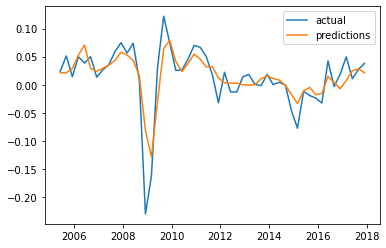

In [6]:
# performance on the train set
plt.plot(train_preds.date, train_preds.actuals, label="actual") 
plt.plot(train_preds.date, train_preds.predictions, label="predictions")
plt.legend();

In [7]:
# getting predictions on the test set
test_preds = model.predict(data, only_actuals_obs=True).loc[lambda x: x.date > train_end_date,:] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

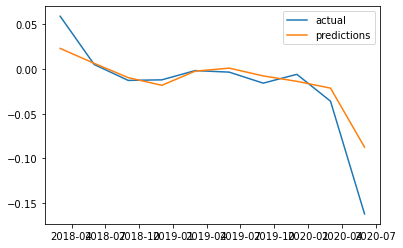

In [8]:
# performance on the test set
plt.plot(test_preds.date, test_preds.actuals, label="actual") 
plt.plot(test_preds.date, test_preds.predictions, label="predictions")
plt.legend();

In [9]:
# saving a trained model
dill.dump(model, open("trained_model.pkl", mode='wb'))

In [10]:
# loading a trained model
trained_model = dill.load(open("trained_model.pkl", "rb", -1))

# Realistic model evaluation scenario
The test set above assumes full data for each test observation, this is rarely the case with economic data. The process below outlines how to check the performance of the model on different data vintages, i.e. how the data would have looked at various points in time leading up to the prediction period.

In [11]:
# data setup
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_world", "x_de", "x_uk", "ipi_cn", "x_vol_world2"]] # random subset of columns for simplicity
train_end_date = "2017-12-01" # training data through 2017
training = data.loc[data.date <= train_end_date,:]
target = "x_world"

### pub_lags
This is a vector of dimensions 1 x n_features. I.e. the number of independent variables in the model, this means NOT including the target variable. So for a model with a 200 x 10 dataframe, with 200 observations and 10 columns, the pub_lags vector should have 9 entries, one for each variable less the target column.
<br><br>
Its function is to provide the publication lag/schedule for each series to be able to generate data vintages via the `gen_ragged_X` function. The contents should therefore be the number of periods of lag each series experiences when published. For example, if there are three independent variables in a monthly model, GDP, exports, and the business confidence index, and they are published with a 3, 2, and 1 month lag, respectively, the lag vector should read `[3,2,1]`, or in whatever order the columns are in the original dataframe. If the target period is June, values with a lag of 2 are available until April. A value of 1 means values are available to May. A lag value of 0 means that if we are in June, June values are available. 
<br><br>
The units of the lag is the units of the original dataframe, i.e. the highest granularity of data. The monthly example above should then be extrapolated for the case of e.g. daily or quarterly data.

In [12]:
# example publication lags. Means x_jp comes out 1 month later, x_de 0 months later, x_uk 2 months later, ipi_cn 3 months later, x_vol_world2 3 months later
pub_lags = [1, 0, 2, 3, 3]

In [13]:
# model instantiation and training
model = LSTM(training, target, n_timesteps=12, n_models=10)
model.train(quiet=True)

Training model 1
Training model 2
Training model 3
Training model 4
Training model 5
Training model 6
Training model 7
Training model 8
Training model 9
Training model 10


### model assessment on vintages
The first testing example in this notebook made predictions on full datasets, i.e as if the lags for all variables was 0. This is an unrealistic scenario, so a better evaluation of a nowcasting model's performance is testing it on incomplete datasets that reflect real data publication conditions. The code below therefore uses the `pub_lags` vector and the `ragged_preds` function to create vintage datasets to test on. The below example will find performance of the model as if predictions were made 1, 2, and 3 months before the target period, in the target period, and 1 month after the target period. The appropriate prediction periods should be chosen as relevant for the use case of the nowcast. Testing continues after the target period because of publication lags. If we are nowcasting Q2 numbers and are in June, that does not mean that we have full data for June. Some figures from Q2 months may not come out until July or August, therefore the testing on vintages past the target period.

### ragged_preds
This function creates data vintages using a publication schedule, `pub_lags` vector, explained above, then generates predictions on these ragged datasets. The second parameter, `lag`, is the simulated period offset. It can be interpreted as the last period with full data relative to the target period. If we are nowcasting Q2, i.e. June, a lag of 0 simulates being in June. I.e. June is the last month with full data (for variables with lag 0). A lag of -1 simulates being in May, where May is the last full month. A lag of 1 simulates being in July, where variables with a lag of 1 now have June data as well. How many missings will be generated for a series can be calculated with `-1*(lag - variable_pub_lag)`. E.g. we set the lagged period to -2 months back, and the variable has a 1 month publication lag, `-1*(-2-1)=3`, so the last three months will be set to missing. The `data` parameter should be passed the dataset to predict, if different from the dataset the model was trained on. 
<br><br>
**note** if `"ARMA"` is chosen for `fill_ragged_edges_func`, `ragged_preds` will take significantly longer to calculate, as ARMA models have to be fit on every observation's data vintages.
<br><br>
Generally we should expect to see evaluation metrics get better the further ahead in time we move, as more data is available.

In [14]:
# performance on a single vintage, 2 months back of target period
lag = -2
test_preds = model.ragged_preds(pub_lags, lag, data=data).loc[lambda x: x.date > train_end_date] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on

# different evaluation metrics
RMSE = np.sqrt(np.mean((test_preds.actuals - test_preds.predictions)**2))
MAE = np.mean(np.abs((test_preds.actuals - test_preds.predictions)))

print(f"RMSE: {np.round(RMSE, 4)}")
print(f"MAE: {np.round(MAE, 4)}")

RMSE: 0.0257
MAE: 0.021


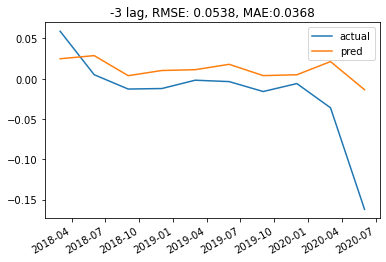

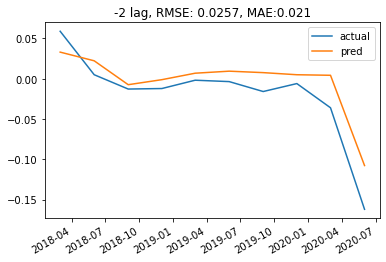

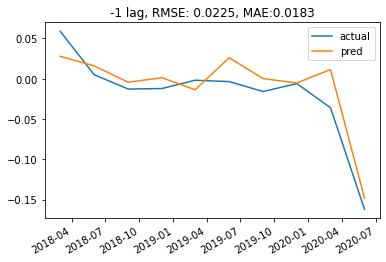

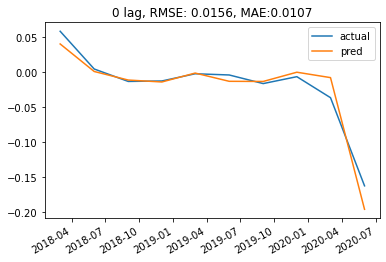

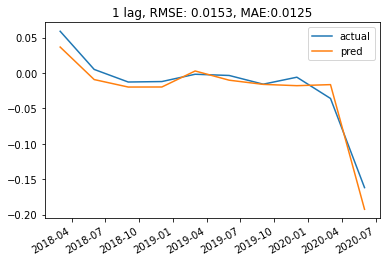

In [15]:
# visualization of performance over time, to see how performance develops
for lag in [-3, -2, -1, 0, 1]: # 3 months back, 2 months back, 1 month back, month-of, 1 month ahead vintages
    test_preds = model.ragged_preds(pub_lags, lag, data=data).loc[lambda x: x.date > train_end_date] # passing the full dataset, then filtering only for predictions on dates the model wasn't trained on
    
    # different evaluation metrics, test_data.y is actuals
    RMSE = np.sqrt(np.mean((test_preds.actuals - test_preds.predictions)**2))
    MAE = np.mean(np.abs((test_preds.actuals - test_preds.predictions)))
    
    # plotting results
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    
    ax.plot(test_preds.date, test_preds.actuals, label="actual")
    ax.plot(test_preds.date, test_preds.predictions, label=f"pred")
    plt.title(f"{lag} lag, RMSE: {np.round(RMSE,4)}, MAE:{np.round(MAE,4)}")
    plt.legend()
    plt.show()

In [16]:
# to make sure the right values are being set to missing, the gen_ragged_X function can be called to see what's being passed for ragged prediction
model.X[0,:,0] # the X object has three dimensions, n_obs x n_timesteps x n_features, this is the first observation, the first feature

array([-1.94665401e-02,  6.41786089e-05,  7.21203830e-03,  1.06082605e-02,
        3.92971848e-02, -1.48268313e-02,  1.09373230e-02, -2.74475538e-03,
        3.02965665e-02, -3.27576576e-03, -1.02967146e-02, -1.39156223e-02])

In [17]:
# the gen_ragged_X function returns a ragged X and the corresponding y. We select [0] to get the ragged X, then [0,:,0] to get the first observation, the first feature
# we see the last two observations have been replace with the series mean, because we have a lag of -1, and the first feature (x_jp) has a lag of 1, -1*(-1-1) = the last 2 values set to missing, then replaced with the mean
# if we had set fill_ragged_edges_func in model instantiation to "ARMA", the last two values would have been replaced with ARMA estimations instead of the series mean (the default)
model.gen_ragged_X(pub_lags, -1)[0][0,:,0]

array([-1.94665401e-02,  6.41786089e-05,  7.21203830e-03,  1.06082605e-02,
        3.92971848e-02, -1.48268313e-02,  1.09373230e-02, -2.74475538e-03,
        3.02965665e-02, -3.27576576e-03,  4.18520337e-03,  4.18520337e-03])

# Different filling NA options
The default behavior of the model is to fill missings/NAs with the mean of the series. There are however other approaches, this section will outline different implementations available in the library.

### 2 types of missing values:
- _within-series missings_: E.g. quarterly data that is forced to be monthly will have NAs in between observations, or if a series just has some missing values within it. Fill these with the `fill_na_func` parameter in `LSTM` instantiation. The function must take a series and return a scalar, e.g. `np.nanmean`, `np.nanmedian`, etc.

- _ragged edges_: I.e. observations that haven't come out yet because of publication lag. These happen exclusively at the end of the series. Fill these with the `fill_ragged_edges_func` parameter in `LSTM` instantiation. The function must take a series and return a scalar, e.g. `np.nanmean`, `np.nanmedian`, or enter `"ARMA"` to use ARMA estimation. Don't pass anything to use the same function as passed to `fill_na_func`.

In [18]:
# data setup
data = pd.read_csv("data.csv", parse_dates=["date"])
data = data.loc[:, ["date", "x_jp", "x_de", "ipi_cn", "x_vol_world2", "x_world"]] # random subset of columns for simplicity
features = ["x_jp", "x_de", "ipi_cn", "x_vol_world2"]
target = "x_world"

In [19]:
# looking at the end of the dataset, we can see some ragged edges
data.loc[:, features].tail(10)

x_jp      x_de  ipi_cn  x_vol_world2
217  0.027627  0.004619     NaN           NaN
218 -0.014492 -0.099137  -0.011     -0.017065
219 -0.113030 -0.266919   0.039           NaN
220 -0.041397  0.104712   0.044           NaN
221  0.009955  0.169252   0.048     -0.150345
222  0.069343  0.069704     NaN           NaN
223  0.057047  0.061412     NaN           NaN
224  0.038700  0.026040     NaN           NaN
225  0.029190       NaN     NaN           NaN
226       NaN       NaN     NaN           NaN

In [20]:
# we can fill these using the mean of the series. x_vol_world2, a quarterly variable, has additionally had its within-series missings filled with the series mean as well
tmp = LSTM(data, "x_world", n_timesteps=12, fill_na_func=np.nanmean).dataset["na_filled_dataset"][-10:,:-1] # pass fill_na_func=np.nanmedian to use the median
pd.DataFrame(tmp, columns=features)

x_jp      x_de    ipi_cn  x_vol_world2
0  0.027627  0.004619  0.115697      0.004903
1 -0.014492 -0.099137 -0.011000     -0.017065
2 -0.113030 -0.266919  0.039000      0.004903
3 -0.041397  0.104712  0.044000      0.004903
4  0.009955  0.169252  0.048000     -0.150345
5  0.069343  0.069704  0.115697      0.004903
6  0.057047  0.061412  0.115697      0.004903
7  0.038700  0.026040  0.115697      0.004903
8  0.029190  0.005243  0.115697      0.004903
9  0.003397  0.005243  0.115697      0.004903

In [21]:
# ragged edges can also be filled by ARMA estimation, in the below example ARMA parameters were estimated using `pmdarima.arima.auto_arima` then fit to the data to fill ragged edges
# ragged edges have now been filled using ARMA models for each series. x_vol_world2 within-series missings continue to be filled in with the series mean as passed to the `fill_na_func`
tmp = LSTM(data, "x_world", n_timesteps=12, fill_na_func=np.nanmean, fill_ragged_edges_func="ARMA").dataset["na_filled_dataset"][-10:,:-1]
pd.DataFrame(tmp, columns=features)

x_jp      x_de    ipi_cn  x_vol_world2
0  0.027627  0.004619  0.115697      0.004903
1 -0.014492 -0.099137 -0.011000     -0.017065
2 -0.113030 -0.266919  0.039000      0.004903
3 -0.041397  0.104712  0.044000      0.004903
4  0.009955  0.169252  0.048000     -0.150345
5  0.069343  0.069704  0.048205      0.004903
6  0.057047  0.061412  0.049725      0.004903
7  0.038700  0.026040  0.051523     -0.128865
8  0.029190  0.007008  0.052900      0.004903
9  0.012272  0.005250  0.054285      0.004903

### Also used in `gen_ragged_X`/`ragged_preds` functions
The NA-filling parameters specified in model instantiation are also used in the ragged functions, which artifically create ragged edges based on publication lags.

In [22]:
# this is what the last observation in the data looks like, i.e. no missings
model = LSTM(data, "x_world", n_timesteps=12, fill_na_func=np.nanmean, fill_ragged_edges_func=np.nanmean)
tmp = model.X[-1,:,:]
pd.DataFrame(tmp, columns=features)

x_jp      x_de    ipi_cn  x_vol_world2
0  -0.014974  0.001702  0.048000      0.004903
1  -0.029245 -0.012135  0.044000      0.004903
2  -0.014317  0.005756  0.058000      0.004903
3  -0.045167  0.011326  0.047000      0.004903
4  -0.005281 -0.017942  0.062000      0.004903
5  -0.006490  0.012664  0.069000     -0.001741
6  -0.032822 -0.006319  0.115697      0.004903
7   0.027627  0.004619  0.115697      0.004903
8  -0.014492 -0.099137 -0.011000     -0.017065
9  -0.113030 -0.266919  0.039000      0.004903
10 -0.041397  0.104712  0.044000      0.004903
11  0.009955  0.169252  0.048000     -0.150345

In [23]:
# this is what the last observation in the artificial ragged data looks like with a lag of -1. 
# E.g. the last 2 values for x_jp have been replaced by the mean, because it has a pub_lag of 1 plus the lag of -1 means two missings, etc.
tmp = model.gen_ragged_X(pub_lags=[1,2,1,3], lag=-1)[0][-1,:,:]
pd.DataFrame(tmp, columns=features)

x_jp      x_de    ipi_cn  x_vol_world2
0  -0.014974  0.001702  0.048000      0.004903
1  -0.029245 -0.012135  0.044000      0.004903
2  -0.014317  0.005756  0.058000      0.004903
3  -0.045167  0.011326  0.047000      0.004903
4  -0.005281 -0.017942  0.062000      0.004903
5  -0.006490  0.012664  0.069000     -0.001741
6  -0.032822 -0.006319  0.115697      0.004903
7   0.027627  0.004619  0.115697      0.004903
8  -0.014492 -0.099137 -0.011000      0.004903
9  -0.113030  0.005243  0.039000      0.004903
10  0.003397  0.005243  0.115697      0.004903
11  0.003397  0.005243  0.115697      0.004903

In [24]:
# if the model has been instantiated with ARMA for filling ragged edges, the artificial missings would have been replaced with ARMA estimations, not the mean
# the ARMA method takes longer to generate the artificial ragged data because ARMA models need to be fit on all the artificial vintages
model = LSTM(data, "x_world", n_timesteps=12, fill_na_func=np.nanmean, fill_ragged_edges_func="ARMA")
model.train(quiet=True)
tmp = model.gen_ragged_X(pub_lags=[1,2,1,3], lag=-1)[0][-1,:,:]
pd.DataFrame(tmp, columns=features)

Training model 1


x_jp      x_de    ipi_cn  x_vol_world2
0  -0.014974  0.001702  0.048000      0.004903
1  -0.029245 -0.012135  0.044000      0.004903
2  -0.014317  0.005756  0.058000      0.004903
3  -0.045167  0.011326  0.047000      0.004903
4  -0.005281 -0.017942  0.062000      0.004903
5  -0.006490  0.012664  0.069000     -0.001741
6  -0.032822 -0.006319  0.115697      0.004903
7   0.027627  0.004619  0.115697      0.004903
8  -0.014492 -0.099137 -0.011000     -0.003492
9  -0.113030  0.002923  0.039000      0.004903
10 -0.019894  0.004622  0.043275      0.004903
11 -0.026520  0.004622  0.034755     -0.002268

In [25]:
# time can be saved by passing dates to `start_date` and/or `end_date` on either `ragged_preds` or `gen_ragged_X` to only generate ragged predictions for e.g. a test set, not all dates
# ragged predictions on all dates
model.ragged_preds(pub_lags=[1,2,1,3], lag=-1)

date   actuals  predictions
0  2005-06-01  0.023618     0.028715
1  2005-09-01  0.051245     0.010349
2  2005-12-01  0.014421     0.041394
3  2006-03-01  0.049846     0.030551
4  2006-06-01  0.038543     0.040898
..        ...       ...          ...
56 2019-06-01 -0.003545     0.007967
57 2019-09-01 -0.015856    -0.001025
58 2019-12-01 -0.005995    -0.018560
59 2020-03-01 -0.036013    -0.010461
60 2020-06-01 -0.161963    -0.065689

[61 rows x 3 columns]

In [26]:
# ragged predictions on just 2017-2019 for faster calculation
model.ragged_preds(pub_lags=[1,2,1,3], lag=-1, start_date="2017-01-01", end_date="2019-12-01")

date   actuals  predictions
0  2017-03-01  0.049740    -0.020901
1  2017-06-01  0.010703     0.020952
2  2017-09-01  0.027313     0.011769
3  2017-12-01  0.038043     0.008146
4  2018-03-01  0.058902     0.006319
5  2018-06-01  0.004988     0.013325
6  2018-09-01 -0.012785    -0.014661
7  2018-12-01 -0.012139    -0.005810
8  2019-03-01 -0.001823    -0.015715
9  2019-06-01 -0.003545     0.007967
10 2019-09-01 -0.015856    -0.001025
11 2019-12-01 -0.005995    -0.018560

ARMA models can also be fit on a smaller subset of series history by passing a shorter dataframe to `model.predict(data=short_df)` or `model.ragged_preds(data=short_df)`. If the model was trained on data from 2000-2015, `short_df` could be the data just from e.g. 2015-2018 to only use series history from 2015 for the ARMA models. Passing a dataframe with data from 2000-2018 would use the full series history.